# 彼得與狼：強化學習入門

在本教程中，我們將學習如何將強化學習應用於尋路問題。這個場景靈感來自俄羅斯作曲家[謝爾蓋·普羅科菲耶夫](https://en.wikipedia.org/wiki/Sergei_Prokofiev)的音樂童話故事[《彼得與狼》](https://en.wikipedia.org/wiki/Peter_and_the_Wolf)。這是一個關於年輕的先鋒彼得的故事，他勇敢地走出家門，來到森林空地追捕狼。我們將訓練機器學習算法，幫助彼得探索周圍的區域並建立最佳的導航地圖。

首先，讓我們匯入一些有用的庫：


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## 強化學習概述

**強化學習**（Reinforcement Learning，簡稱 RL）是一種學習技術，通過進行多次實驗，讓我們能夠學習到某個**代理**在某個**環境**中的最佳行為。在這個環境中，代理應該有一個由**獎勵函數**定義的**目標**。

## 環境

為了簡化起見，我們假設彼得的世界是一個大小為 `width` x `height` 的方形棋盤。在這個棋盤上的每個格子可以是以下幾種之一：
* **地面**，彼得和其他生物可以在上面行走
* **水域**，顯然無法在上面行走
* **樹**或**草地**——一個可以稍作休息的地方
* **蘋果**，代表彼得很樂意找到的食物來填飽肚子
* **狼**，這是危險的，應該盡量避開

為了與這個環境互動，我們將定義一個名為 `Board` 的類。為了避免讓這個筆記本過於雜亂，我們已將所有與棋盤相關的代碼移到了單獨的 `rlboard` 模組中，現在我們將導入該模組。你可以查看這個模組的內容，了解實現細節的內部運作方式。


In [2]:
from rlboard import *

現在讓我們創建一個隨機棋盤，看看它的樣子：


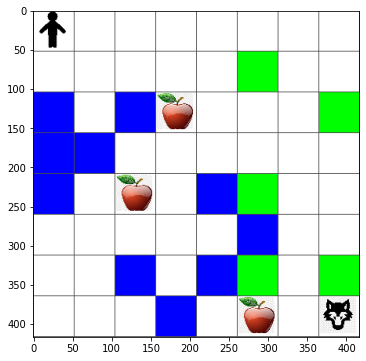

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## 行動與策略

在我們的例子中，彼得的目標是找到一顆蘋果，同時避開狼和其他障礙物。為了達成這個目標，他基本上可以四處走動直到找到蘋果。因此，在任何位置，他可以選擇以下其中一個行動：向上、向下、向左或向右。我們將這些行動定義為一個字典，並將它們對應到相應的座標變化。例如，向右移動（`R`）會對應到一組座標變化 `(1,0)`。


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

我們的代理（Peter）的策略是由一個所謂的**政策**來定義的。讓我們來看看最簡單的政策，稱為**隨機漫步**。

## 隨機漫步

首先，讓我們通過實現隨機漫步策略來解決我們的問題。


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

讓我們多次運行隨機漫步實驗，看看平均步數：


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## 獎勵函數

為了讓我們的策略更智能，我們需要了解哪些行動比其他行動「更好」。


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

建立一個 Q-表，或多維陣列。由於我們的棋盤具有 `width` x `height` 的尺寸，我們可以用形狀為 `width` x `height` x `len(actions)` 的 numpy 陣列來表示 Q-表：


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

將 Q-表傳遞給繪圖函數以便在板上可視化該表：


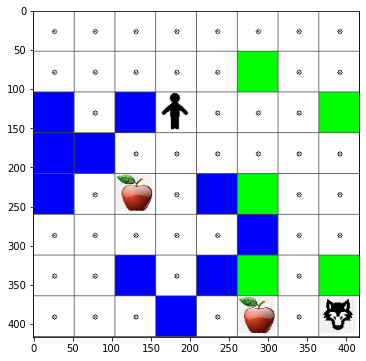

In [9]:
m.plot(Q)

## Q-Learning 的精髓：Bellman 方程與學習算法

撰寫學習算法的偽代碼：

* 初始化 Q-表 Q，為所有狀態和動作賦予相同的數值
* 設定學習率 $\alpha\leftarrow 1$
* 重複模擬多次
   1. 從隨機位置開始
   1. 重複以下步驟
        1. 在狀態 $s$ 選擇一個動作 $a$
        2. 執行動作並移動到新狀態 $s'$
        3. 如果遇到遊戲結束條件，或總獎勵過低，則退出模擬  
        4. 計算新狀態的獎勵 $r$
        5. 根據 Bellman 方程更新 Q-函數：$Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. 更新總獎勵並降低 $\alpha$。

## 探索與利用

最佳的方法是平衡探索與利用。隨著我們對環境的了解越來越多，我們會更傾向於遵循最佳路徑，但偶爾選擇未探索的路徑。

## Python 實現

現在我們準備實現學習算法。在此之前，我們還需要一些函數，將 Q-表中的任意數值轉換為對應動作的概率向量：


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

我們在原始向量中加入一個小量的 `eps`，以避免在初始情況下，當向量的所有組成部分都相同時出現除以 0 的情況。

實際的學習算法將進行 5000 次實驗，也稱為 **epochs**：


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

在執行此算法後，Q-表應該更新為定義每個步驟中不同行動吸引力的值。在此處可視化該表：


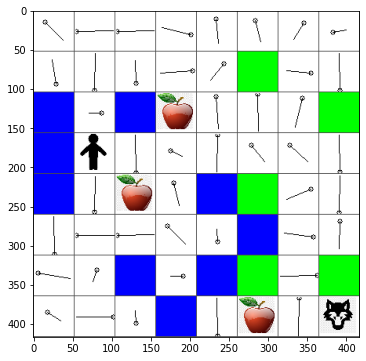

In [12]:
m.plot(Q)

## 檢查策略

由於 Q-Table 列出了每個狀態下各個行動的「吸引力」，因此利用它來定義我們世界中的高效導航是相當簡單的。在最簡單的情況下，我們只需選擇對應於 Q-Table 中最高值的行動：


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

如果你多次嘗試上述程式碼，你可能會注意到有時它會「卡住」，需要按下筆記本中的停止按鈕來中斷執行。

> **任務 1：** 修改 `walk` 函數，限制路徑的最大長度為一定的步數（例如 100），並觀察上述程式碼是否會不時返回此值。

> **任務 2：** 修改 `walk` 函數，使其不會回到之前已經到過的地方。這將防止 `walk` 進入循環，但代理仍可能被「困住」在某個無法逃脫的位置。


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


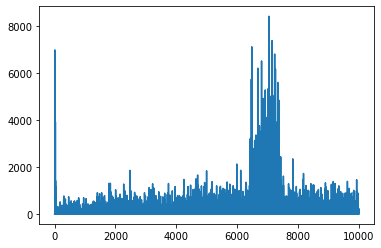

In [15]:
plt.plot(lpath)

我們可以看到，起初平均路徑長度有所增加。這可能是因為當我們對環境一無所知時，很容易陷入不利的狀態，例如掉進水裡或遇到狼。隨著我們學到更多知識並開始利用這些知識，我們可以在環境中探索更長的時間，但仍然不太清楚蘋果的位置。

當我們學到足夠多的知識後，代理達成目標變得更容易，路徑長度開始縮短。然而，我們仍然保持探索的開放性，因此經常偏離最佳路徑，嘗試新的選擇，這使得路徑比最優解稍長。

我們在這張圖上還觀察到，某個時刻路徑長度突然增加。這表明該過程具有隨機性，並且我們可能在某些時候通過覆寫新值來“破壞”Q-Table的係數。理想情況下，應該通過降低學習率來最小化這種情況（例如，在訓練的後期，我們只用小幅度調整Q-Table的值）。

總體來說，重要的是要記住，學習過程的成功與質量在很大程度上取決於一些參數，例如學習率、學習率衰減和折扣因子。這些參數通常被稱為**超參數**，以區別於我們在訓練過程中優化的**參數**（例如Q-Table的係數）。尋找最佳超參數值的過程被稱為**超參數優化**，這是一個值得單獨討論的主題。


## 練習
#### 一個更真實的《彼得與狼》的世界

在我們的情境中，彼得幾乎可以四處移動而不會感到疲倦或飢餓。在一個更真實的世界裡，他需要時不時坐下來休息，還需要進食。我們來通過實現以下規則，讓這個世界更接近現實：

1. 每次從一個地方移動到另一個地方，彼得會失去**能量**並增加一些**疲勞**。
2. 彼得可以通過吃蘋果來獲得更多能量。
3. 彼得可以通過在樹下或草地上休息來消除疲勞（也就是走到有樹或草的棋盤位置——綠色區域）。
4. 彼得需要找到並殺死狼。
5. 為了殺死狼，彼得需要達到一定的能量和疲勞水平，否則他會輸掉戰鬥。

根據遊戲規則修改上述的獎勵函數，運行強化學習算法來學習贏得遊戲的最佳策略，並比較隨機行走與你的算法在遊戲勝負數量上的結果。

> **注意**：你可能需要調整超參數以使其正常運行，特別是訓練的回合數。由於遊戲的成功（與狼戰鬥）是一個罕見事件，你可以預期需要更長的訓練時間。



---

**免責聲明**：  
本文件已使用 AI 翻譯服務 [Co-op Translator](https://github.com/Azure/co-op-translator) 進行翻譯。雖然我們致力於提供準確的翻譯，但請注意，自動翻譯可能包含錯誤或不準確之處。原始文件的母語版本應被視為權威來源。對於關鍵資訊，建議使用專業人工翻譯。我們對因使用此翻譯而引起的任何誤解或誤釋不承擔責任。
